In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set()
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import tree, datasets, svm
from sklearn.metrics import accuracy_score
# from KaggleAux import predict as ka

In [42]:
train_data = pd.read_csv("./raw/cs-training.csv");
test_data = pd.read_csv("./raw/cs-test.csv");

# Data profiling

In [43]:
# Get a first glimpse at data
train_data.head(5)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


**MonthlyIncome** has 29731 missing values out of 150000 entries (19,8% missing...).
It will be critical to decide what to do with this value: either ignore it or try to guess it.

In [45]:
# train_data.columns
# Renaming first column to 'id' just because...
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})
test_data = test_data.rename(columns={'Unnamed: 0': 'id'})

#### Quick descriptive stats

In [130]:
def val_frequency(dfColumn):
    df = dfColumn.value_counts(dropna=False).sort_index(na_position='first').reset_index().reset_index(drop=True)
    print(df)

val_frequency(train_data['RevolvingUtilizationOfUnsecuredLines'])
val_frequency(train_data['age'])
val_frequency(train_data['NumberOfTime30-59DaysPastDueNotWorse'])
val_frequency(train_data['DebtRatio'])
val_frequency(train_data['MonthlyIncome'])
val_frequency(train_data['NumberOfOpenCreditLinesAndLoans'])
val_frequency(train_data['NumberOfTimes90DaysLate'])
val_frequency(train_data['NumberRealEstateLoansOrLines'])
val_frequency(train_data['NumberOfTime60-89DaysPastDueNotWorse'])
val_frequency(train_data['NumberOfDependents'])


               index  RevolvingUtilizationOfUnsecuredLines
0           0.000000                                 10878
1           0.000008                                     1
2           0.000010                                     1
3           0.000013                                     1
4           0.000014                                     1
5           0.000015                                     1
6           0.000015                                     1
7           0.000016                                     1
8           0.000016                                     1
9           0.000019                                     1
10          0.000019                                     1
11          0.000021                                     1
12          0.000021                                     1
13          0.000022                                     1
14          0.000024                                     1
15          0.000027                                    

In [46]:
# print(test_data.describe());
print(train_data.describe());

                  id  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                            

## Dictionnaire des data

**SeriousDlqin2yrs** = defaut de paiement d'un client, c'est notre variable a predire.

**RevolvingUtilizationOfUnsecuredLines** = % de crédit utilise (toutes cartes de credit confondues hors biens immobiliers)

**age** = age du client

**DebtRatio** = Taux de depenses par rapport aux revenus

**MonthlyIncome** = Revenu mensuel

**NumberOfOpenCreditLinesAndLoans** = Nombre de ligne de credit ouvertes

**NumberRealEstateLoansOrLines** = Nombre de credit immobilier ou hypotheques

**NumberOfDependents** = Nombre de personnes a charge

**NumberOfTime30-59DaysPastDueNotWorse** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de 30 a 59 jours dans les 2 dernieres annees.

**NumberOfTime60-89DaysPastDueNotWorse** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de 60 a 89 jours dans les 2 dernieres annees.

**NumberOfTimes90DaysLate** = Nombre de fois que l'emprunteur a ete en souffrance de paiement de paiement de 90 jours ou plus



# Analyses basiques

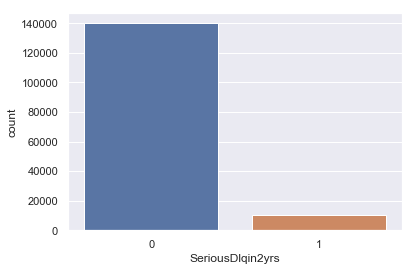

In [18]:
sns.countplot(x='SeriousDlqin2yrs', data=train_data);

In [39]:
# Il y a ENORMEMENT plus de payeur que de NON-payeurs: rapport de 1 non-payeur pour 14 payeur...
# Faisons une estimation completement biaisee et non reflechie... tout le monde paie :)
test_data['SeriousDlqin2yrs'] = 0
test_data[['id', 'SeriousDlqin2yrs']].to_csv('./predictions/everybody_pays.csv', index=False, header=['id','Probability'])
# kaggle competitions submit -c GiveMeSomeCredit -f ~/Documents/fil_rouge/predictions/everybody_pays.csv -m "Testing dummy submission: everybody pays"
# Kaggle score: 0.5000 (on est meme pas les derniers du classement !!!)

# Part 2

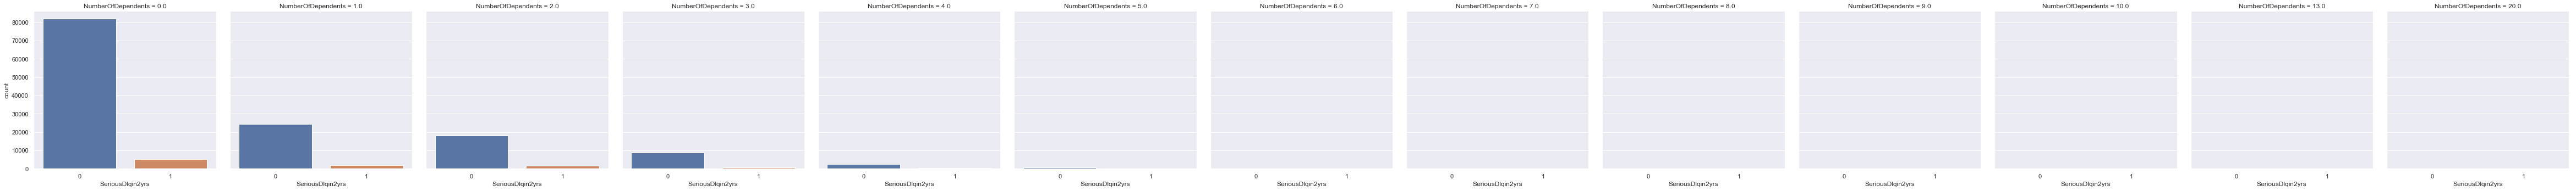

In [136]:
# sns.countplot(x='NumberOfDependents', data=train_data);
sns.catplot(x='SeriousDlqin2yrs', col='NumberOfDependents', kind='count', data=train_data);

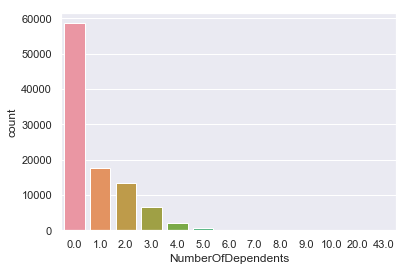

In [138]:
sns.countplot(x='NumberOfDependents', data=test_data);

In [183]:
NumDepsSummary = train_data.fillna("NaN").groupby('NumberOfDependents', as_index=False).agg({"SeriousDlqin2yrs": ["sum", "count"]})
NumDepsSummary['ratio']  = NumDepsSummary["SeriousDlqin2yrs"]["sum"]/NumDepsSummary["SeriousDlqin2yrs"]["count"]
NumDepsSummary

NumberOfDependents SeriousDlqin2yrs            ratio
                                   sum  count          
0                   0             5095  86902  0.058629
1                   1             1935  26316  0.073529
2                   2             1584  19522  0.081139
3                   3              837   9483  0.088263
4                   4              297   2862  0.103774
5                   5               68    746  0.091153
6                   6               24    158  0.151899
7                   7                5     51  0.098039
8                   8                2     24  0.083333
9                   9                0      5  0.000000
10                 10                0      5  0.000000
11                 13                0      1  0.000000
12                 20                0      1  0.000000
13                NaN              179   3924  0.045617

More dependents = more risks ??
Not really clear at this point as the distribution of this ratio seems rather normal with a peak between 4 and 6 dependents representing more risks.
We should be carefull with this dimension as it seems to partially explain risk. In fact, intuitively we can understand that a person with 20 dependents but without debts is more likely to pay than another person with 0 dependents but a 200% debt ratio... 
We might take this feature as a ponderation factor, but not as deterministic factor. For exemple, a person with 6 dependents AND a 100% debt ratio COMBINED might have a higher failure probability.

Finally, we will need to handle some null (NaN) values, either by removing or filling them.

age SeriousDlqin2yrs           ratio
                     sum count          
0     0                0     1  0.000000
1    21               13   183  0.071038
2    22               36   434  0.082949
3    23               70   641  0.109204
4    24               98   816  0.120098
5    25              121   953  0.126967
6    26              147  1193  0.123219
7    27              166  1338  0.124066
8    28              205  1560  0.131410
9    29              179  1702  0.105170
10   30              209  1937  0.107899
11   31              217  2038  0.106477
12   32              233  2050  0.113659
13   33              246  2239  0.109870
14   34              210  2155  0.097448
15   35              241  2246  0.107302
16   36              237  2379  0.099622
17   37              227  2521  0.090044
18   38              235  2631  0.089320
19   39              280  2987  0.093740
20   40              264  3093  0.085354
21   41              294  3122  0.094170
22   42              289  3082  0.093770
23   43              276  3208  0.086035
24   44              242  3294  0.073467
25   45              284  3502  0.081097
26   46              324  3714  0.087237
27   47              306  3719  0.082280
28   48              286  3806  0.075145
29   49              313  3837  0.081574
..  ...              ...   ...       ...
56   76               24  1183  0.020287
57   77               18  1099  0.016379
58   78               24  1054  0.022770
59   79               22   981  0.022426
60   80               19   876  0.021689
61   81                9   774  0.011628
62   82               19   647  0.029366
63   83               10   512  0.019531
64   84                8   480  0.016667
65   85                9   483  0.018634
66   86                6   407  0.014742
67   87                8   357  0.022409
68   88                8   313  0.025559
69   89                9   276  0.032609
70   90                3   198  0.015152
71   91                5   154  0.032468
72   92                0    93  0.000000
73   93                1    87  0.011494
74   94                1    47  0.021277
75   95                1    45  0.022222
76   96                0    18  0.000000
77   97                0    17  0.000000
78   98                0     6  0.000000
79   99                2     9  0.222222
80  101                1     3  0.333333
81  102                0     3  0.000000
82  103                0     3  0.000000
83  105                0     1  0.000000
84  107                0     1  0.000000
85  109                0     2  0.000000

[86 rows x 4 columns]

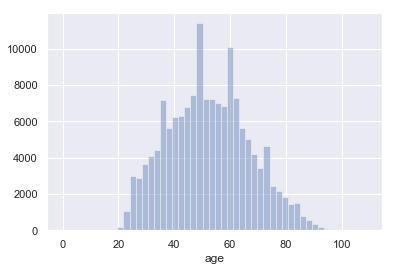

In [188]:
sns.distplot(train_data.age, kde=False);
AgeSummary = train_data.fillna("NaN").groupby('age', as_index=False).agg({"SeriousDlqin2yrs": ["sum", "count"]})
AgeSummary['ratio']  = AgeSummary["SeriousDlqin2yrs"]["sum"]/AgeSummary["SeriousDlqin2yrs"]["count"]
AgeSummary

Even though further analysis is needed at this stage, this view suggests that age is a crucial factor when it comes to pay back credits. Younger people tends to fail more that older ones.

In [196]:
# DebtRatioSummary = train_data.fillna("NaN").groupby('DebtRatio', as_index=False).agg({"SeriousDlqin2yrs": ["sum", "count"]})
# DebtRatioSummary['ratio']  = DebtRatioSummary["SeriousDlqin2yrs"]["sum"]/DebtRatioSummary["SeriousDlqin2yrs"]["count"]
# DebtRatioSummary

# sns.distplot(train_data.DebtRatio, kde=False);
# train_data.groupby('SeriousDlqin2yrs').DebtRatio.hist(alpha=0.6);

# sns.stripplot(x='SeriousDlqin2yrs', y='DebtRatio', data=train_data, alpha=0.3, jitter=True);
# sns.swarmplot(x='SeriousDlqin2yrs', y='DebtRatio', data=train_data);

DebtRatio SeriousDlqin2yrs           ratio
                                   sum count          
0            0.000000              340  4113  0.082665
1            0.000026                0     1  0.000000
2            0.000037                0     1  0.000000
3            0.000039                0     1  0.000000
4            0.000066                0     1  0.000000
5            0.000075                0     1  0.000000
6            0.000080                0     1  0.000000
7            0.000086                0     1  0.000000
8            0.000091                0     1  0.000000
9            0.000092                0     1  0.000000
10           0.000094                0     1  0.000000
11           0.000095                0     1  0.000000
12           0.000095                0     1  0.000000
13           0.000095                0     4  0.000000
14           0.000096                0     1  0.000000
15           0.000099                0     1  0.000000
16           0.000102                0     1  0.000000
17           0.000105                0     1  0.000000
18           0.000106                0     1  0.000000
19           0.000109                0     1  0.000000
20           0.000112                0     1  0.000000
21           0.000112                0     1  0.000000
22           0.000114                0     1  0.000000
23           0.000120                0     1  0.000000
24           0.000120                0     1  0.000000
25           0.000122                0     1  0.000000
26           0.000123                0     1  0.000000
27           0.000123                0     1  0.000000
28           0.000125                0     1  0.000000
29           0.000126                0     1  0.000000
...               ...              ...   ...       ...
114164   24591.000000                0     1  0.000000
114165   25033.000000                0     1  0.000000
114166   25801.000000                0     1  0.000000
114167   26668.000000                0     1  0.000000
114168   26675.000000                1     1  1.000000
114169   29136.000000                0     1  0.000000
114170   30295.000000                0     1  0.000000
114171   32843.000000                1     1  1.000000
114172   33409.000000                0     1  0.000000
114173   33448.000000                0     1  0.000000
114174   34102.000000                0     1  0.000000
114175   34719.000000                0     1  0.000000
114176   36705.000000                0     1  0.000000
114177   38793.000000                1     1  1.000000
114178   40362.000000                0     1  0.000000
114179   40385.000000                0     1  0.000000
114180   43843.000000                0     1  0.000000
114181   49112.000000                0     1  0.000000
114182   52112.000000                0     1  0.000000
114183   60212.000000                0     1  0.000000
114184   61106.500000                0     1  0.000000
114185   61907.000000                0     1  0.000000
114186  101320.000000                0     1  0.000000
114187  106885.000000                0     1  0.000000
114188  110952.000000                0     1  0.000000
114189  168835.000000                0     1  0.000000
114190  220516.000000                0     1  0.000000
114191  307001.000000                0     1  0.000000
114192  326442.000000                0     1  0.000000
114193  329664.000000                0     1  0.000000

[114194 rows x 4 columns]